# Image Captioning using the Flickr8k Dataset
Keras-built neural network trained on the Flickr8k Dataset. When given an image, the model is able to output an image caption describing it.

Since each image has multiple captions corresponding to it, we'll be using an approach called multi-caption training in which we create multiple training examples for each image, where each example pairs the image with one of its corresponding captions.

In [74]:
# Tensorflow
import tensorflow as tf

# Data Handling
import pandas as pd
import numpy as np
import os
import random

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data Preprocessing
from tensorflow.keras.utils import img_to_array, load_img, to_categorical, pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Models
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# Layers
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM, Bidirectional, add
)

# Misc
from tqdm import tqdm

Our image data is stored in the `flickr8k/Images` directory in this repository and our captions are stored in `flickr8k/captions.txt`. Let's read the captions and create a map from the filenames to the captions.

In [3]:
# Read the data.
df = pd.read_csv('data/captions.txt', header=0, delimiter=',', names=['image', 'caption'])

# Create a map of image to captions.
captions = df.groupby('image')['caption'].apply(list).to_dict()

# Display a random image and its captions.
captions["1001773457_577c3a7d70.jpg"]

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

## Label Preprocessing
First we need to preprocess the labels, cleaning them out and converting them into vectors of integers. Here, we clear out unnecessary characters and make each word lowercase. We also add each caption to an array called `all_captions` that we can pass into a Keras tokenizer.

In [4]:
# Create a list of all the captions.
all_captions = []

# Iterate over all the filenames.
for filename, img_captions in captions.items():
    # Iterate over each caption for the specific file.
    for i, caption in enumerate(img_captions):
        # Convert the caption to lowercase.
        caption = caption.lower()

        # Remove all the special characters.
        caption = caption.replace("[^a-z]+", "")

        # Remove all additional spaces.
        caption = caption.replace("\s+", " ")

        # Add starting and ending tokens.
        caption = f"<start>{caption}<end>"

        # Update the caption.
        img_captions[i] = caption

        # Append the caption to the list of all captions.
        all_captions.append(caption)

# Display the updated caption.
captions["1001773457_577c3a7d70.jpg"]

['<start>a black dog and a spotted dog are fighting<end>',
 '<start>a black dog and a tri-colored dog playing with each other on the road .<end>',
 '<start>a black dog and a white dog with brown spots are staring at each other in the street .<end>',
 '<start>two dogs of different breeds looking at each other on the road .<end>',
 '<start>two dogs on pavement moving toward each other .<end>']

Now, we need to use the Keras `Tokenizer` to tokenize the text, essentially transforming it into a sequence of numbers. This is a result of the fact that neural networks are only able to process and output information when they are in the form of Tensors.

In [5]:
# Initial the tokenizer. Don't set the num_words parameter.
tokenizer = Tokenizer()

# Fit the tokenizer on the captions.
tokenizer.fit_on_texts(all_captions)

# Iterate over all of the files.
for filename in captions.keys():
    # Replace the raw text captions with the sequences.
    captions[filename] = tokenizer.texts_to_sequences(captions[filename])

# Store the size of the vocabulary.
vocab_size = len(tokenizer.word_index) + 1

# Display the first few captions.
captions["1001773457_577c3a7d70.jpg"]

[[3, 1, 15, 9, 8, 1, 842, 9, 17, 343, 2],
 [3, 1, 15, 9, 8, 1, 1574, 235, 9, 34, 10, 137, 82, 6, 5, 151, 2],
 [3, 1, 15, 9, 8, 1, 14, 9, 10, 27, 1000, 17, 640, 22, 137, 82, 4, 5, 72, 2],
 [3, 13, 31, 12, 740, 2651, 89, 22, 137, 82, 6, 5, 151, 2],
 [3, 13, 31, 6, 726, 804, 321, 137, 82, 2]]

## Image Preprocessing
Now that we've done some basic setting up of the labels, it's time to focus on images. We first will download the `MobileNetV2` pre-trained convolutional neural network.

In [73]:
image_net = MobileNetV2(weights='imagenet', include_top=True)

Now that we've installed the pre-trained model, we need to create our own model that utilizes it. Our goal is to only extract the features of the image from the pre-trained CNN, which will enable us to train our model on the features of the image rather than the raw image data. This is far more efficient.

In [7]:
# Model to extract features from the images.
model = Model(inputs=image_net.input, outputs=image_net.layers[-2].output)

Now that we've defined this model, we're going to create a dictionary that maps from image/filenames to the respective features outputted by the `MobileNetV2` model. We do this because we'll be training the model on the same input features multiple times (but slightly different input labels). This will make a little more sense later.

In [8]:
# Create a dictionary to map the image name to the features.
image_features = {}

# Iterate over all the images.
for filename in tqdm(captions.keys()):
    #Load our images in the target size of 224x224.
    img = load_img(f"./data/Images/{filename}", target_size=(224, 224))

    # Vectorize the image.
    x = img_to_array(img)

    # Expand the dimensions of the image.
    x = np.expand_dims(x, axis = 0)

    # Calculate the flattened features array.
    features = model.predict(x, verbose=0)
    features = np.reshape(features, (features.shape[1]))
    
    # Store the features array.
    image_features[filename] = features

  0%|          | 0/8091 [00:00<?, ?it/s]2023-03-30 09:39:33.190402: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-30 09:39:33.475842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 8091/8091 [04:41<00:00, 28.70it/s]


## Train-test Split
Now that we've preprocessed all of our data, it's time to split it up in preparation for training.

In [75]:
# Shuffle our array.
images = list(captions.keys())
random.shuffle(list(captions.keys()))

# Seperate our data into training and testing data.
# 7000 training images and 1091 test images.
train_images = images[:7000]
test_images = images[7000:]

len(train_images), len(test_images)

TypeError: 'NoneType' object is not subscriptable

## Creating Training Instances
Now that we've set pretty everything up, we need to create "training instances". In order to understand what we're doing, we first need to look into how the model will work.

The model, when given an image, will generate a text sequence, but it is only able to generate a single word at a time. This means that to generate the entire text sequence, 1) we'll need to repeatedly call the `model.predict` method, and 2) the model will need two input layers. One input layer will represent the image data and the second one will be the text sequence.

Due to this, we'll need to create multiple training instances for each caption. Each one will represent the same image data, but the captions for each word will contain the incremented sequence. 

For example, say we have an image with the caption: `<start> a big fat cat <end>`. We would have 6 different instances:
```
<start>
<start> a
<start> a big
<start> a big fat
<start> a big fat cat
<start> a big fat cat <end>
```

This will train the model to generate more accurate captions.

In [10]:
#find the maximum length of a description in a dataset
maxlen = max(len(caption.split()) for caption in all_captions)

# Create three empty arrays.
# One for image inputs, one for caption inputs, and the final one for full labels.
x_img, x_caption, y = [], [], []

# Iterate over each training image.
for filename in tqdm(train_images):
    # Retrieve the image features.
    image = image_features[filename]

    # Iterate over each caption 
    for sequence in captions[filename]:
        # Iterate over each value (word) in the sequence.
        # We skip the first word in the sequence because that's just the start code.
        for i in range(1, len(sequence)):
            # Our input value will be the sequence up until point `i`.
            # We also right-pad the sequence to the maximum length.
            input_sequence = sequence[:i]
            input_sequence = pad_sequences([input_sequence], maxlen=maxlen)[0]

            # Our output sequence is simply the next word.
            output_sequence = sequence[i]

            # Append the data to the arrays.
            x_img.append(image)
            x_caption.append(input_sequence)
            y.append(output_sequence)

# Convert the arrays to numpy arrays.
x_img = np.array(x_img)
x_caption = np.array(x_caption)

# Log that we're done with the x arrays.
print("x arrays done")

# Create an empty array for the output labels.
labels = np.zeros((len(y), vocab_size))

# Iterate over the output labels.
for i, label in enumerate(y):
    # Convert the label to a one-hot vector.
    labels[i] = to_categorical([label], num_classes=vocab_size)[0]

# Log that we're done with the y array.
print("y array done")


# Output the shapes of the arrays.
x_img.shape, x_caption.shape, labels.shape

100%|██████████| 7000/7000 [00:01<00:00, 3902.73it/s]


x arrays done
y array done


((413035, 1280), (413035, 38), (413035, 8494))

## Defining our Model
Now comes to fun part: defining our model! 

The model will follow an encoder-decoder architecture, which is perfect for sequence to sequence models like this one. An encoder-decoder model consists of two main components, an encoder and a decoder. First, the encoder is used to encode the input sequence into a feature vector, which, second, the decoder will use to generate the output sequence.

We've actually already partially defined the encoder in this model: the (pre-trained) CNN, which takes our image, and "encodes" it by extracting the features of the image. Our CNN outputs a 2048-dimension vector (so a vector with a length of 2048).

The decoder is an LSTM (Long-Short Term Memory) RNN that processes the partial image caption and then generates the next word based on the features of the image. Our decoder uses two LSTM layers, with one being bidirectional, the model is able to capture more information and learn more complex betters in the data.

In [11]:
# Define our image input and the feature encoding layers to process it.
image_input = Input(shape=(1280,))                                              # 1280 is the size of the flattened features array.
dropout_1 = Dropout(0.2)(image_input)                                           # Dropout layer to prevent overfitting.
dense_1 = Dense(256, activation='relu')(dropout_1)                              # Dense layer to reduce the size of the features array.

# Define our caption input and the sequence encoding layers to process it.
caption_input = Input(shape=(maxlen,))                                          # The maximum length of a caption.
embedding = Embedding(vocab_size, 200, mask_zero=True)(caption_input)  # Embedding layer to convert the words to vectors.
dropout_2 = Dropout(0.2)(embedding)                                             # Dropout layer to prevent overfitting.

# Now we'll define the LSTM layers to process the encoded caption sequence.
lstm_1 = Bidirectional(LSTM(256, return_sequences=True))(dropout_2)             # LSTM layer to process the sequence.
lstm_2 = LSTM(256)(lstm_1)                                                      # LSTM layer to process the sequence.

# Combine the image and caption inputs.
decoder_1 = add([dense_1, lstm_2])                                              # Add the image and caption inputs.
decoder_2 = Dense(256, activation='relu')(decoder_1)                            # Dense layer to reduce the size of the features array.

# We'll use a softmax activation function to predict the next word.
output = Dense(vocab_size, activation='softmax')(decoder_2)             # Dense layer that outputs prediction for the next word.

# Define the model. We have two inputs for the image and caption, and one output for the prediction.
model = Model(inputs=[image_input, caption_input], outputs=output)

Remember that embedding layer? We can actually define the weights for that using GloVe, a pre-trained unsupervised learning algorithm for obtaining vector representations for words. We've loaded the weight values for that data in the `glove` directory. 

You can download it [here](https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation?select=glove.6B.200d.txt).

We're going to retrieve all necessary words from GloVe and replace our embedding layer's weights with the outputs from GloVe.

In [12]:
# Create an empty numpy array that we will eventually replace the Embedding layer weights with.
embedding_matrix = np.zeros((vocab_size, 200))

# Create a dictionary to map the words to their GloVe vectors.
embedding_dict = {}

# Open the file containing the GloVe vectors.
with open("./data/glove.6B.200d.txt", "r") as glove:
    # Retrieve each line in the file.
    values = glove.readlines()

    # Iterate over each line.
    for value in values:
        # Retrieve the word.
        word = value.split()[0]

        # Continue if the word is not in our tokenizer.
        if word not in tokenizer.word_index:
            continue

        # Retrieve the vector. Note that we skip the first value because it's the word.
        vector = np.array(value.split()[1:], dtype="float32")

        # Store the vector in the dictionary.
        embedding_dict[word] = vector

# Iterate over each word in the tokenizer.
for word, i in tokenizer.word_index.items():
    # Retrieve the vector for the word.
    vector = embedding_dict.get(word)

    # If the word has a vector, store it in the embedding matrix.
    if vector is not None:
        embedding_matrix[i] = vector

Now that we have our embedding matrix, we can replace the weights of the model's Embedding layer.

In [13]:
# Our embedding layer is the second layer in the model.
print(model.layers[1])

# Replace the weights of the embedding layer with our embedding matrix.
model.layers[1].set_weights([embedding_matrix])

# Freeze the weights of the embedding layer.
model.layers[1].trainable = False

Now it's time to compile our model. We'll be using the `adam` optimizer and `categorical_crossentropy`. 

The `adam` optimizer is a good choice as it is computationally efficient and requires little memory, making it suitable for large-scale problems like image captioning. 

The `categorical_crossentropy` is often used for multi-class classificaiton problems. Although this model generates a text sequence, at each time step, it predicts the next word in the caption using a one-hot encoded representation, which technically is classification. Categorical cross-entropy loss will measure the dissimilarity between the predicted probability distribution and the true distribution.

In [14]:
# Compile the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Next, we're going to fit the model using thirty epochs. We'll 

In [15]:
print("Starting training...")

# Check if we have any saved weights.
if(os.path.exists("./models/weights.h5")):
    # Load the weights.
    model.load_weights("./models/weights.h5")

# If they don't exist, train the model.
else:
    # Iterate over 30 epochs.
    model.fit([x_img, x_caption], labels, epochs = 30, batch_size = 64, verbose = 1)

    # Save the model weights.
    model.save_weights("weights.h5")

Starting training...


# Testing
Now that we've trained the model, it's time to test it. First, let's define a function for generating captions. We'll first display the image before preprocessing some of the information. Finally, we'll generate our sequence, word by word. 

In [69]:
# Function to generate a caption given an image.
def generate_caption(filename):
    # Display the image.
    img = mpimg.imread(f"data/Images/{filename}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Retrieve the image features.
    image = image_features[filename]
    image = np.expand_dims(image, axis=0)

    # Define our sequence. We will start with the start sequence token and add to it.
    full_sequence = "<start>"

    # Iterate over the maximum caption length.
    for i in range(maxlen):
        # Process the sequence.
        sequence = tokenizer.texts_to_sequences([full_sequence])[0]
        sequence = pad_sequences([sequence], maxlen=maxlen)

        # Predict the next word.
        prediction = model.predict([image, sequence], verbose=0)
        word = tokenizer.index_word[np.argmax(prediction)]

        # Add the word to the sequence.
        full_sequence += " " + word

        # If we've reached the end of the caption, stop.
        if word == "end":
            break

    # Remove the start and end tokens.
    caption = " ".join(full_sequence.split()[1:-1]).replace("end", "")

    # Print the predicted caption.
    print("Predicted caption:", caption)

Now, let's test it on a few random images from our testing set.

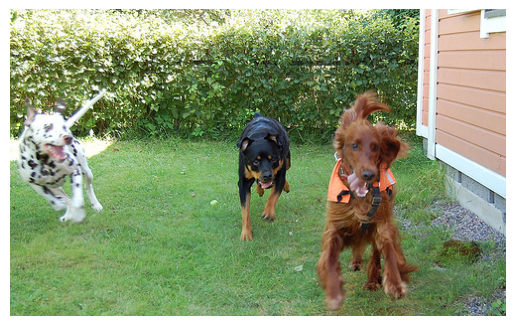

Predicted caption: a dog is running through a field


In [70]:
# Generate a caption for the image.
generate_caption("1488937076_5baa73fc2a.jpg")

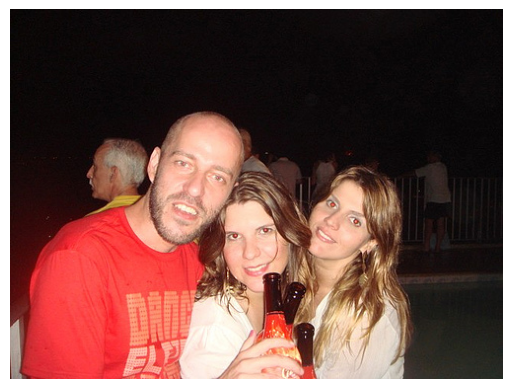

Predicted caption: a man in a red shirt and a woman in a white shirt are walking on a sidewalk


In [71]:
# Generate a caption for the image.
generate_caption("3171451305_f87b9e09ee.jpg")

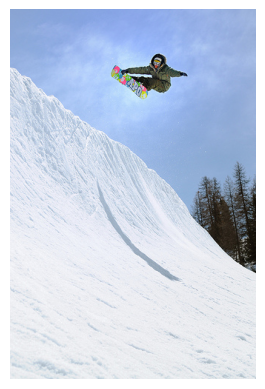

Predicted caption: a man is skiing down a snowy hill


In [72]:
# Generate a caption for the image.
generate_caption("3474958471_9106beb07f.jpg")

# Conclusion
In conclusion, the neural network developed in this notebook demonstrates a decent(ish) performance, but there is still a lot of room for improvement. The model would likely benefit from additional training and would definitely perform significantly better when trained on a more extensive dataset, as it would be more capable of capturing intricate details of various images in order to write more accurate and relevant captions.

For me, this experiement was an excellent learning experience and provided me with an opportunity to explore and experiment with different architectures and approaches to image captioning. 